In [1]:
from stock_history_download_script import msft_hist
import matplotlib

In [2]:
msft_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13 05:00:00,0.054693,0.062736,0.054693,0.060055,1031788800,0.0,0.0
1986-03-14 05:00:00,0.060055,0.063272,0.060055,0.062199,308160000,0.0,0.0
1986-03-17 05:00:00,0.062199,0.063808,0.062199,0.063272,133171200,0.0,0.0
1986-03-18 05:00:00,0.063272,0.063808,0.061127,0.061663,67766400,0.0,0.0
1986-03-19 05:00:00,0.061663,0.062199,0.060055,0.060591,47894400,0.0,0.0


<Axes: >

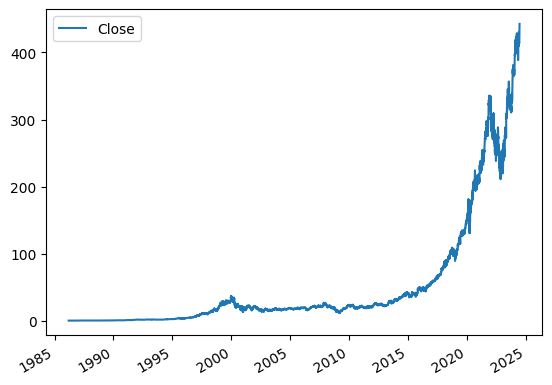

In [3]:
msft_hist.plot.line(y="Close", use_index=True)

In [4]:
import os
import pandas as pd

DATA_PATH = "msft_data.json"

if os.path.exists(DATA_PATH):
    with open(DATA_PATH, "r") as f:
        msft_hist = pd.read_json(f)

else:
    import yfinance as yf

    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period="max")

    msft_hist.to_json(DATA_PATH)

# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns={'Close': 'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

data.head()

,Actual_Close,Target
1986-03-13 05:00:00,0.060055,NaN
1986-03-14 05:00:00,0.062199,1.0
1986-03-17 05:00:00,0.063272,1.0
1986-03-18 05:00:00,0.061663,0.0
1986-03-19 05:00:00,0.060591,0.0


In [5]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

In [6]:
msft_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14 05:00:00,0.054693,0.062736,0.054693,0.060055,1.031789e+09,0.0,0.0
1986-03-17 05:00:00,0.060055,0.063272,0.060055,0.062199,3.081600e+08,0.0,0.0
1986-03-18 05:00:00,0.062199,0.063808,0.062199,0.063272,1.331712e+08,0.0,0.0
1986-03-19 05:00:00,0.063272,0.063808,0.061127,0.061663,6.776640e+07,0.0,0.0


0.5127175368139224

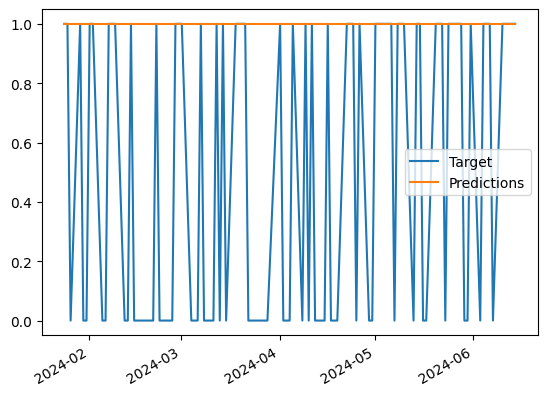

In [1]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import precision_score

DATA_PATH = "msft_data.json"

if os.path.exists(DATA_PATH):
    with open(DATA_PATH, "r") as f:
        msft_hist = pd.read_json(f)

else:
    import yfinance as yf

    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period="max")

    msft_hist.to_json(DATA_PATH)

# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns={'Close': 'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

i = 1000
step = 750

train = data.iloc[0:i].copy()
test = data.iloc[i:(i+step)].copy()
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])

preds = model.predict_proba(test[predictors])[:,1]
preds = pd.Series(preds, index=test.index)
preds[preds > .6] = 1
preds[preds<=.6] = 0

predictions = []
# Loop over the dataset in increments
for i in range(1000, data.shape[0], step):
    # Split into train and test sets
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()

    # Fit the random forest model
    model.fit(train[predictors], train["Target"])

    # Make predictions
    preds = model.predict_proba(test[predictors])[:,1]
    preds = pd.Series(preds, index=test.index)
    preds[preds > .6] = 1
    preds[preds<=.6] = 0

    # Combine predictions and test values
    combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

    predictions.append(combined)

def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit the random forest model
        model.fit(train[predictors], train["Target"])

        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0

        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

        predictions.append(combined)

    return pd.concat(predictions)

predictions = backtest(data, model, predictors)

predictions["Predictions"].value_counts()

predictions["Target"].value_counts()

precision_score(predictions["Target"], predictions["Predictions"])






0.5505226480836237

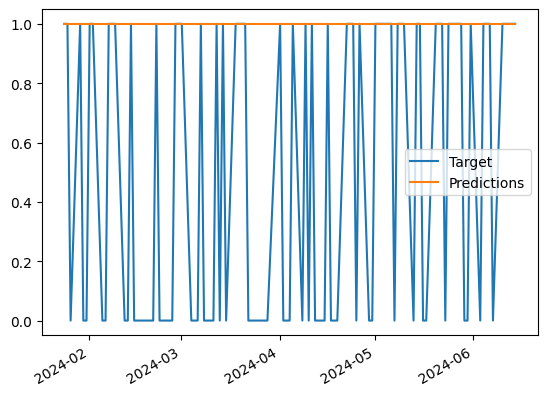

In [2]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import precision_score

DATA_PATH = "msft_data.json"

if os.path.exists(DATA_PATH):
    with open(DATA_PATH, "r") as f:
        msft_hist = pd.read_json(f)

else:
    import yfinance as yf

    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period="max")

    msft_hist.to_json(DATA_PATH)

# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns={'Close': 'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

i = 1000
step = 750

train = data.iloc[0:i].copy()
test = data.iloc[i:(i+step)].copy()
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])

preds = model.predict_proba(test[predictors])[:,1]
preds = pd.Series(preds, index=test.index)
preds[preds > .6] = 1
preds[preds<=.6] = 0

predictions = []
# Loop over the dataset in increments
for i in range(1000, data.shape[0], step):
    # Split into train and test sets
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()

    # Fit the random forest model
    model.fit(train[predictors], train["Target"])

    # Make predictions
    preds = model.predict_proba(test[predictors])[:,1]
    preds = pd.Series(preds, index=test.index)
    preds[preds > .6] = 1
    preds[preds<=.6] = 0

    # Combine predictions and test values
    combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

    predictions.append(combined)

def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit the random forest model
        model.fit(train[predictors], train["Target"])

        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0

        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

        predictions.append(combined)

    return pd.concat(predictions)

predictions = backtest(data, model, predictors)

predictions["Predictions"].value_counts()

predictions["Target"].value_counts()

precision_score(predictions["Target"], predictions["Predictions"])

weekly_mean = data.rolling(7).mean()["Close"]
quarterly_mean = data.rolling(90).mean()["Close"]
annual_mean = data.rolling(365).mean()["Close"]

weekly_trend = data.shift(1).rolling(7).sum()["Target"]

data["weekly_mean"] = weekly_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]

data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]

predictions = backtest(data.iloc[365:], model, full_predictors)

precision_score(predictions["Target"], predictions["Predictions"])





In [3]:
predictions["Predictions"].value_counts()


Predictions
0.0    7989
1.0     287
Name: count, dtype: int64

<Axes: >

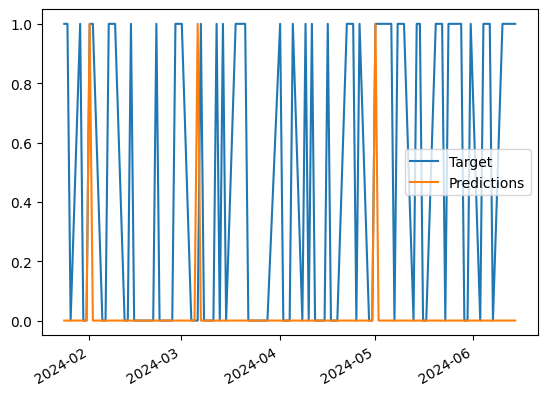

In [4]:
predictions.iloc[-100:].plot()


In [5]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import precision_score

DATA_PATH = "tqqq_data.json"

if os.path.exists(DATA_PATH):
    with open(DATA_PATH, "r") as f:
        tqqq_hist = pd.read_json(f)

else:
    import yfinance as yf

    tqqq = yf.Ticker("TQQQ")
    tqqq_hist = tqqq.history(period="max")

    tqqq_hist.to_json(DATA_PATH)

# Ensure we know the actual closing price
data = tqqq_hist[["Close"]]
data = data.rename(columns={'Close': 'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = tqqq.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
tqqq_prev = tqqq_hist.copy()
tqqq_prev = tqqq_prev.shift(1)

# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(tqqq_prev[predictors]).iloc[1:]

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

i = 1000
step = 750

train = data.iloc[0:i].copy()
test = data.iloc[i:(i+step)].copy()
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])

preds = model.predict_proba(test[predictors])[:,1]
preds = pd.Series(preds, index=test.index)
preds[preds > .6] = 1
preds[preds<=.6] = 0

predictions = []
# Loop over the dataset in increments
for i in range(1000, data.shape[0], step):
    # Split into train and test sets
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()

    # Fit the random forest model
    model.fit(train[predictors], train["Target"])

    # Make predictions
    preds = model.predict_proba(test[predictors])[:,1]
    preds = pd.Series(preds, index=test.index)
    preds[preds > .6] = 1
    preds[preds<=.6] = 0

    # Combine predictions and test values
    combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

    predictions.append(combined)

def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit the random forest model
        model.fit(train[predictors], train["Target"])

        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0

        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

        predictions.append(combined)

    return pd.concat(predictions)

predictions = backtest(data, model, predictors)

predictions["Predictions"].value_counts()

predictions["Target"].value_counts()

precision_score(predictions["Target"], predictions["Predictions"])

weekly_mean = data.rolling(7).mean()["Close"]
quarterly_mean = data.rolling(90).mean()["Close"]
annual_mean = data.rolling(365).mean()["Close"]

weekly_trend = data.shift(1).rolling(7).sum()["Target"]

data["weekly_mean"] = weekly_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]

data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]

predictions = backtest(data.iloc[365:], model, full_predictors)

precision_score(predictions["Target"], predictions["Predictions"])

predictions["Predictions"].value_counts()





AttributeError: 'Ticker' object has no attribute 'rolling'

In [6]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import precision_score

DATA_PATH = "tqqq_data.json"

if os.path.exists(DATA_PATH):
    with open(DATA_PATH, "r") as f:
        tqqq_hist = pd.read_json(f)

else:
    import yfinance as yf

    tqqq = yf.Ticker("TQQQ")
    tqqq_hist = tqqq.history(period="max")

    tqqq_hist.to_json(DATA_PATH)

# Ensure we know the actual closing price
data = tqqq_hist[["Close"]]
data = data.rename(columns={'Close': 'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = data.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
tqqq_prev = tqqq_hist.copy()
tqqq_prev = tqqq_prev.shift(1)

# Create our training data
predictors = import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import precision_score

DATA_PATH = "tqqq_data.json"

if os.path.exists(DATA_PATH):
    with open(DATA_PATH, "r") as f:
        tqqq_hist = pd.read_json(f)

else:
    import yfinance as yf

    tqqq = yf.Ticker("TQQQ")
    tqqq_hist = tqqq.history(period="max")

    tqqq_hist.to_json(DATA_PATH)

# Ensure we know the actual closing price
data = tqqq_hist[["Close"]]
data = data.rename(columns={'Close': 'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = tqqq.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
tqqq_prev = tqqq_hist.copy()
tqqq_prev = tqqq_prev.shift(1)

# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(tqqq_prev[predictors]).iloc[1:]

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

i = 1000
step = 750

train = data.iloc[0:i].copy()
test = data.iloc[i:(i+step)].copy()
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])

preds = model.predict_proba(test[predictors])[:,1]
preds = pd.Series(preds, index=test.index)
preds[preds > .6] = 1
preds[preds<=.6] = 0

predictions = []
# Loop over the dataset in increments
for i in range(1000, data.shape[0], step):
    # Split into train and test sets
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()

    # Fit the random forest model
    model.fit(train[predictors], train["Target"])

    # Make predictions
    preds = model.predict_proba(test[predictors])[:,1]
    preds = pd.Series(preds, index=test.index)
    preds[preds > .6] = 1
    preds[preds<=.6] = 0

    # Combine predictions and test values
    combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

    predictions.append(combined)

def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit the random forest model
        model.fit(train[predictors], train["Target"])

        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0

        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

        predictions.append(combined)

    return pd.concat(predictions)

predictions = backtest(data, model, predictors)

predictions["Predictions"].value_counts()

predictions["Target"].value_counts()

precision_score(predictions["Target"], predictions["Predictions"])

weekly_mean = data.rolling(7).mean()["Close"]
quarterly_mean = data.rolling(90).mean()["Close"]
annual_mean = data.rolling(365).mean()["Close"]

weekly_trend = data.shift(1).rolling(7).sum()["Target"]

data["weekly_mean"] = weekly_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]

data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]

predictions = backtest(data.iloc[365:], model, full_predictors)

precision_score(predictions["Target"], predictions["Predictions"])

predictions["Predictions"].value_counts()



["Close", "Volume", "Open", "High", "Low"]
data = data.join(tqqq_prev[predictors]).iloc[1:]

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

i = 1000
step = 750

train = data.iloc[0:i].copy()
test = data.iloc[i:(i+step)].copy()
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])

preds = model.predict_proba(test[predictors])[:,1]
preds = pd.Series(preds, index=test.index)
preds[preds > .6] = 1
preds[preds<=.6] = 0

predictions = []
# Loop over the dataset in increments
for i in range(1000, data.shape[0], step):
    # Split into train and test sets
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()

    # Fit the random forest model
    model.fit(train[predictors], train["Target"])

    # Make predictions
    preds = model.predict_proba(test[predictors])[:,1]
    preds = pd.Series(preds, index=test.index)
    preds[preds > .6] = 1
    preds[preds<=.6] = 0

    # Combine predictions and test values
    combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

    predictions.append(combined)

def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit the random forest model
        model.fit(train[predictors], train["Target"])

        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0

        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

        predictions.append(combined)

    return pd.concat(predictions)

predictions = backtest(data, model, predictors)

predictions["Predictions"].value_counts()

predictions["Target"].value_counts()

precision_score(predictions["Target"], predictions["Predictions"])

weekly_mean = data.rolling(7).mean()["Close"]
quarterly_mean = data.rolling(90).mean()["Close"]
annual_mean = data.rolling(365).mean()["Close"]

weekly_trend = data.shift(1).rolling(7).sum()["Target"]

data["weekly_mean"] = weekly_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]

data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]

predictions = backtest(data.iloc[365:], model, full_predictors)

precision_score(predictions["Target"], predictions["Predictions"])

predictions["Predictions"].value_counts()





SyntaxError: invalid syntax (2773876657.py, line 33)

In [7]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import precision_score

DATA_PATH = "tqqq_data.json"

if os.path.exists(DATA_PATH):
    with open(DATA_PATH, "r") as f:
        tqqq_hist = pd.read_json(f)

else:
    import yfinance as yf

    tqqq = yf.Ticker("TQQQ")
    tqqq_hist = tqqq.history(period="max")

    tqqq_hist.to_json(DATA_PATH)

# Ensure we know the actual closing price
data = tqqq_hist[["Close"]]
data = data.rename(columns={'Close': 'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = data.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
tqqq_prev = tqqq_hist.copy()
tqqq_prev = tqqq_prev.shift(1)

# Create our training data
predictors = import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import precision_score

DATA_PATH = "tqqq_data.json"

if os.path.exists(DATA_PATH):
    with open(DATA_PATH, "r") as f:
        tqqq_hist = pd.read_json(f)

else:
    import yfinance as yf

    tqqq = yf.Ticker("TQQQ")
    tqqq_hist = tqqq.history(period="max")

    tqqq_hist.to_json(DATA_PATH)

# Ensure we know the actual closing price
data = tqqq_hist[["Close"]]
data = data.rename(columns={'Close': 'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = tqqq.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
tqqq_prev = tqqq_hist.copy()
tqqq_prev = tqqq_prev.shift(1)

# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(tqqq_prev[predictors]).iloc[1:]

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

i = 1000
step = 750

train = data.iloc[0:i].copy()
test = data.iloc[i:(i+step)].copy()
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])

preds = model.predict_proba(test[predictors])[:,1]
preds = pd.Series(preds, index=test.index)
preds[preds > .6] = 1
preds[preds<=.6] = 0

predictions = []
# Loop over the dataset in increments
for i in range(1000, data.shape[0], step):
    # Split into train and test sets
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()

    # Fit the random forest model
    model.fit(train[predictors], train["Target"])

    # Make predictions
    preds = model.predict_proba(test[predictors])[:,1]
    preds = pd.Series(preds, index=test.index)
    preds[preds > .6] = 1
    preds[preds<=.6] = 0

    # Combine predictions and test values
    combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

    predictions.append(combined)

def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit the random forest model
        model.fit(train[predictors], train["Target"])

        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0

        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

        predictions.append(combined)

    return pd.concat(predictions)

predictions = backtest(data, model, predictors)

predictions["Predictions"].value_counts()

predictions["Target"].value_counts()

precision_score(predictions["Target"], predictions["Predictions"])

weekly_mean = data.rolling(7).mean()["Close"]
quarterly_mean = data.rolling(90).mean()["Close"]
annual_mean = data.rolling(365).mean()["Close"]

weekly_trend = data.shift(1).rolling(7).sum()["Target"]

data["weekly_mean"] = weekly_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]

data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]

predictions = backtest(data.iloc[365:], model, full_predictors)

precision_score(predictions["Target"], predictions["Predictions"])

predictions["Predictions"].value_counts()



["Close", "Volume", "Open", "High", "Low"]
data = data.join(tqqq_prev[predictors]).iloc[1:]

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

i = 1000
step = 750

train = data.iloc[0:i].copy()
test = data.iloc[i:(i+step)].copy()
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])

preds = model.predict_proba(test[predictors])[:,1]
preds = pd.Series(preds, index=test.index)
preds[preds > .6] = 1
preds[preds<=.6] = 0

predictions = []
# Loop over the dataset in increments
for i in range(1000, data.shape[0], step):
    # Split into train and test sets
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()

    # Fit the random forest model
    model.fit(train[predictors], train["Target"])

    # Make predictions
    preds = model.predict_proba(test[predictors])[:,1]
    preds = pd.Series(preds, index=test.index)
    preds[preds > .6] = 1
    preds[preds<=.6] = 0

    # Combine predictions and test values
    combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

    predictions.append(combined)

def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit the random forest model
        model.fit(train[predictors], train["Target"])

        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0

        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

        predictions.append(combined)

    return pd.concat(predictions)

predictions = backtest(data, model, predictors)

predictions["Predictions"].value_counts()

predictions["Target"].value_counts()

precision_score(predictions["Target"], predictions["Predictions"])

weekly_mean = data.rolling(7).mean()["Close"]
quarterly_mean = data.rolling(90).mean()["Close"]
annual_mean = data.rolling(365).mean()["Close"]

weekly_trend = data.shift(1).rolling(7).sum()["Target"]

data["weekly_mean"] = weekly_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]

data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]

predictions = backtest(data.iloc[365:], model, full_predictors)

precision_score(predictions["Target"], predictions["Predictions"])

predictions["Predictions"].value_counts()





SyntaxError: invalid syntax (2773876657.py, line 33)

Predictions
0.0    7989
1.0     287
Name: count, dtype: int64

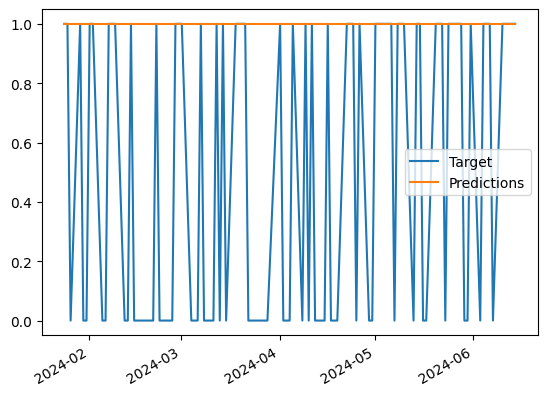

In [8]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import precision_score

DATA_PATH = "msft_data.json"

if os.path.exists(DATA_PATH):
    with open(DATA_PATH, "r") as f:
        msft_hist = pd.read_json(f)

else:
    import yfinance as yf

    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period="max")

    msft_hist.to_json(DATA_PATH)

# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns={'Close': 'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

i = 1000
step = 750

train = data.iloc[0:i].copy()
test = data.iloc[i:(i+step)].copy()
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])

preds = model.predict_proba(test[predictors])[:,1]
preds = pd.Series(preds, index=test.index)
preds[preds > .6] = 1
preds[preds<=.6] = 0

predictions = []
# Loop over the dataset in increments
for i in range(1000, data.shape[0], step):
    # Split into train and test sets
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()

    # Fit the random forest model
    model.fit(train[predictors], train["Target"])

    # Make predictions
    preds = model.predict_proba(test[predictors])[:,1]
    preds = pd.Series(preds, index=test.index)
    preds[preds > .6] = 1
    preds[preds<=.6] = 0

    # Combine predictions and test values
    combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

    predictions.append(combined)

def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit the random forest model
        model.fit(train[predictors], train["Target"])

        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0

        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

        predictions.append(combined)

    return pd.concat(predictions)

predictions = backtest(data, model, predictors)

predictions["Predictions"].value_counts()

predictions["Target"].value_counts()

precision_score(predictions["Target"], predictions["Predictions"])

weekly_mean = data.rolling(7).mean()["Close"]
quarterly_mean = data.rolling(90).mean()["Close"]
annual_mean = data.rolling(365).mean()["Close"]

weekly_trend = data.shift(1).rolling(7).sum()["Target"]

data["weekly_mean"] = weekly_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]

data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]

predictions = backtest(data.iloc[365:], model, full_predictors)

precision_score(predictions["Target"], predictions["Predictions"])

predictions["Predictions"].value_counts()





0.5185185185185185

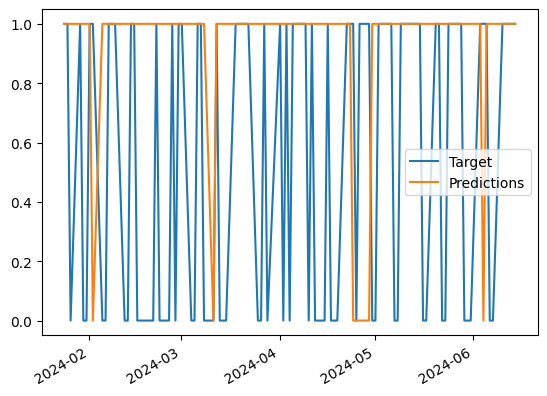

In [10]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import precision_score

DATA_PATH = "tqqq_data.json"

if os.path.exists(DATA_PATH):
    with open(DATA_PATH, "r") as f:
        tqqq_hist = pd.read_json(f)

else:
    import yfinance as yf

    tqqq = yf.Ticker("TQQQ")
    tqqq_hist = tqqq.history(period="max")

    tqqq_hist.to_json(DATA_PATH)

# Ensure we know the actual closing price
data = tqqq_hist[["Close"]]
data = data.rename(columns={'Close': 'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = tqqq_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
tqqq_prev = tqqq_hist.copy()
tqqq_prev = tqqq_prev.shift(1)

# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(tqqq_prev[predictors]).iloc[1:]

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

i = 1000
step = 750

train = data.iloc[0:i].copy()
test = data.iloc[i:(i+step)].copy()
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])

preds = model.predict_proba(test[predictors])[:,1]
preds = pd.Series(preds, index=test.index)
preds[preds > .6] = 1
preds[preds<=.6] = 0

predictions = []
# Loop over the dataset in increments
for i in range(1000, data.shape[0], step):
    # Split into train and test sets
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()

    # Fit the random forest model
    model.fit(train[predictors], train["Target"])

    # Make predictions
    preds = model.predict_proba(test[predictors])[:,1]
    preds = pd.Series(preds, index=test.index)
    preds[preds > .6] = 1
    preds[preds<=.6] = 0

    # Combine predictions and test values
    combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

    predictions.append(combined)

def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit the random forest model
        model.fit(train[predictors], train["Target"])

        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0

        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

        predictions.append(combined)

    return pd.concat(predictions)

predictions = backtest(data, model, predictors)

predictions["Predictions"].value_counts()

predictions["Target"].value_counts()

precision_score(predictions["Target"], predictions["Predictions"])

weekly_mean = data.rolling(7).mean()["Close"]
quarterly_mean = data.rolling(90).mean()["Close"]
annual_mean = data.rolling(365).mean()["Close"]

weekly_trend = data.shift(1).rolling(7).sum()["Target"]

data["weekly_mean"] = weekly_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]

data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]

predictions = backtest(data.iloc[365:], model, full_predictors)

precision_score(predictions["Target"], predictions["Predictions"])





Enter the ticker symbol:  NVDA


0.512280701754386

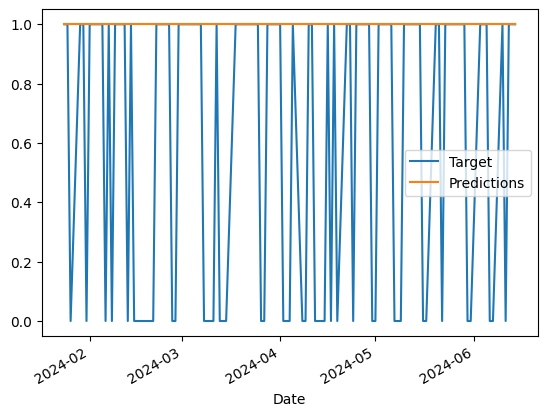

In [3]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import precision_score

ticker = input("Enter the ticker symbol: ")

DATA_PATH = f"{ticker}_data.json"

if os.path.exists(DATA_PATH):
    with open(DATA_PATH, "r") as f:
        stock_hist = pd.read_json(f)

else:
    import yfinance as yf

    stock = yf.Ticker(f"{ticker}")
    stock_hist = stock.history(period="max")

    stock_hist.to_json(DATA_PATH)

# Ensure we know the actual closing price
data = stock_hist[["Close"]]
data = data.rename(columns={'Close': 'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = stock_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
tqqq_prev = stock_hist.copy()
tqqq_prev = tqqq_prev.shift(1)

# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(tqqq_prev[predictors]).iloc[1:]

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

i = 1000
step = 750

train = data.iloc[0:i].copy()
test = data.iloc[i:(i+step)].copy()
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])

preds = model.predict_proba(test[predictors])[:,1]
preds = pd.Series(preds, index=test.index)
preds[preds > .6] = 1
preds[preds<=.6] = 0

predictions = []
# Loop over the dataset in increments
for i in range(1000, data.shape[0], step):
    # Split into train and test sets
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()

    # Fit the random forest model
    model.fit(train[predictors], train["Target"])

    # Make predictions
    preds = model.predict_proba(test[predictors])[:,1]
    preds = pd.Series(preds, index=test.index)
    preds[preds > .6] = 1
    preds[preds<=.6] = 0

    # Combine predictions and test values
    combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

    predictions.append(combined)

def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit the random forest model
        model.fit(train[predictors], train["Target"])

        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0

        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

        predictions.append(combined)

    return pd.concat(predictions)

predictions = backtest(data, model, predictors)

predictions["Predictions"].value_counts()

predictions["Target"].value_counts()

precision_score(predictions["Target"], predictions["Predictions"])

weekly_mean = data.rolling(7).mean()["Close"]
quarterly_mean = data.rolling(90).mean()["Close"]
annual_mean = data.rolling(365).mean()["Close"]

weekly_trend = data.shift(1).rolling(7).sum()["Target"]

data["weekly_mean"] = weekly_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]

data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]

predictions = backtest(data.iloc[365:], model, full_predictors)

precision_score(predictions["Target"], predictions["Predictions"])


